In [1]:
# Load necessary libraries
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
# Set up FRED data connection
# Instructions for getting your FRED API key available at these websites
# https://pypi.org/project/fredapi/ 
# http://api.stlouisfed.org/api_key.html
from fredapi import Fred
fred = Fred(api_key='8770c80e8e192f8eb4e4c7f91096fc47')

# OECD Total share price index 
temp = fred.get_series('SPASTT01USM661N', observation_start='1960-01-01', observation_end='2023-07-01')
df_total_share_price_idx = pd.DataFrame(data = temp, columns=['Total_Price_Index'])
df_total_share_price_idx = df_total_share_price_idx.rename_axis('Date').reset_index()
print(df_total_share_price_idx.head(5))

# Annual dividends
temp = fred.get_series('A2218C1A027NBEA', observation_start='1929-01-01', observation_end='2021-01-01')
df_dividends = pd.DataFrame(data = temp, columns=['Total_Dividends_Paid'])
df_dividends = df_dividends.rename_axis('Date').reset_index()
print(df_dividends.head(5))

# Dividends are measured in total annual dollars. Convert to index, base 2015 to align with share price data
div_base = np.float64(df_dividends.loc[df_dividends["Date"] == "2015-01-01", "Total_Dividends_Paid"])
df_dividends['Total_Dividends_Index'] =  ((df_dividends['Total_Dividends_Paid']/12)/div_base)*100
print(df_dividends.head(5))

# Load CPI 
temp = fred.get_series('CPIAUCSL', observation_start='1960-01-01', observation_end='2023-07-01')
df_cpi = pd.DataFrame(data = temp, columns=['CPI'])
df_cpi = df_cpi.rename_axis('Date').reset_index()

cpi_base = np.float64(df_cpi.loc[df_cpi["Date"] == "2023-07-01", "CPI"])
df_cpi['CPI_ADJ'] = cpi_base / df_cpi['CPI']
print(df_cpi.head(5))

        Date  Total_Price_Index
0 1960-01-01           3.418156
1 1960-02-01           3.255919
2 1960-03-01           3.205570
3 1960-04-01           3.233542
4 1960-05-01           3.205570
        Date  Total_Dividends_Paid
0 1946-01-01                 8.021
1 1947-01-01                 9.309
2 1948-01-01                10.647
3 1949-01-01                10.942
4 1950-01-01                13.076
        Date  Total_Dividends_Paid  Total_Dividends_Index
0 1946-01-01                 8.021               0.038283
1 1947-01-01                 9.309               0.044430
2 1948-01-01                10.647               0.050817
3 1949-01-01                10.942               0.052225
4 1950-01-01                13.076               0.062410


/tmp/ipykernel_86/360596351.py:21: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  div_base = np.float64(df_dividends.loc[df_dividends["Date"] == "2015-01-01", "Total_Dividends_Paid"])


        Date    CPI    CPI_ADJ
0 1960-01-01  29.37  10.372080
1 1960-02-01  29.41  10.357973
2 1960-03-01  29.41  10.357973
3 1960-04-01  29.54  10.312390
4 1960-05-01  29.57  10.301928


/tmp/ipykernel_86/360596351.py:30: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  cpi_base = np.float64(df_cpi.loc[df_cpi["Date"] == "2023-07-01", "CPI"])


In [3]:
# Combine FRED data and define real return for each month
df_fred = pd.merge(df_total_share_price_idx, df_dividends, left_on='Date', right_on='Date')
df_fred = pd.merge(df_fred, df_cpi, left_on='Date', right_on='Date')

df_fred['Real_Price_Index'] = df_fred['Total_Price_Index']*df_fred['CPI_ADJ']
df_fred['Real_Dividends_Index'] = df_fred['Total_Dividends_Index']*df_fred['CPI_ADJ']
df_fred['Real_Price_Index_Lag'] = df_fred['Real_Price_Index'].shift()

df_fred['Real_Month_Return'] = (df_fred['Real_Price_Index'] + df_fred['Real_Dividends_Index']) / df_fred['Real_Price_Index_Lag']
df_fred['Real_Total_Return'] = df_fred['Real_Price_Index']
df_fred['Real_Month_Return'].where(np.arange(len(df_fred))>0, 0).add(1).cumprod() * df_fred.loc[0, 'Real_Total_Return']
df_fred['log_Real_Total_Return'] = np.log(df_fred['Real_Total_Return'])
df_fred['log_Real_Month_Return'] = np.log(df_fred['Real_Month_Return'])
print(df_fred)

         Date  Total_Price_Index  Total_Dividends_Paid  Total_Dividends_Index  \
0  1960-01-01           3.418156                20.114               0.096001   
1  1961-01-01           3.295080                21.063               0.100531   
2  1962-01-01           3.675497                22.973               0.109647   
3  1963-01-01           3.502071                24.332               0.116133   
4  1964-01-01           4.050319                27.955               0.133425   
..        ...                ...                   ...                    ...   
57 2017-01-01         105.023500              1912.605               9.128576   
58 2018-01-01         124.243200              2992.817              14.284265   
59 2019-01-01         111.166200              2393.288              11.422804   
60 2020-01-01         130.905200              2270.184              10.835247   
61 2021-01-01         138.835700              2562.962              12.232632   

        CPI    CPI_ADJ  Rea

In [4]:
# Read in data files 
# GOP term flags
url = "https://github.com/llorracc/as.180.369/blob/main/materials/presidential-term-data/GOP_flag.csv?raw=true"
temp = pd.read_csv(url,dtype=str)
df_gop = pd.DataFrame(temp)

# Add a specific day (e.g., the first day of the month)
df_gop['Date'] = df_gop['Date'] + '.01'

# Convert the complete date string to a datetime object
#df_gop['Date'] = datetime.strptime(df_gop['Date'], '%Y-%m-%d')
df_gop['Date'] = pd.to_datetime(df_gop['Date'])
df_gop['Date'] = df_gop['Date'].dt.normalize()
df_gop['Date'] = df_gop['Date'].dt.floor('D')
print(df_gop.head)

<bound method NDFrame.head of            Date GOP
0    1871-01-01   1
1    1871-02-01   1
2    1871-03-01   1
3    1871-04-01   1
4    1871-05-01   1
...         ...  ..
1826 2023-03-01   0
1827 2023-04-01   0
1828 2023-05-01   0
1829 2023-06-01   0
1830 2023-07-01   0

[1831 rows x 2 columns]>


In [5]:
# Create new data frame that merges GOP flag with returns data
df = pd.merge(df_fred, df_gop, left_on='Date', right_on='Date')
print(df.head(5))

        Date  Total_Price_Index  Total_Dividends_Paid  Total_Dividends_Index  \
0 1960-01-01           3.418156                20.114               0.096001   
1 1960-01-01           3.418156                20.114               0.096001   
2 1961-01-01           3.295080                21.063               0.100531   
3 1961-01-01           3.295080                21.063               0.100531   
4 1962-01-01           3.675497                22.973               0.109647   

     CPI    CPI_ADJ  Real_Price_Index  Real_Dividends_Index  \
0  29.37  10.372080         35.453389              0.995731   
1  29.37  10.372080         35.453389              0.995731   
2  29.84  10.208713         33.638526              1.026287   
3  29.84  10.208713         33.638526              1.026287   
4  30.04  10.140746         37.272280              1.111899   

   Real_Price_Index_Lag  Real_Month_Return  Real_Total_Return  \
0                   NaN                NaN          35.453389   
1         

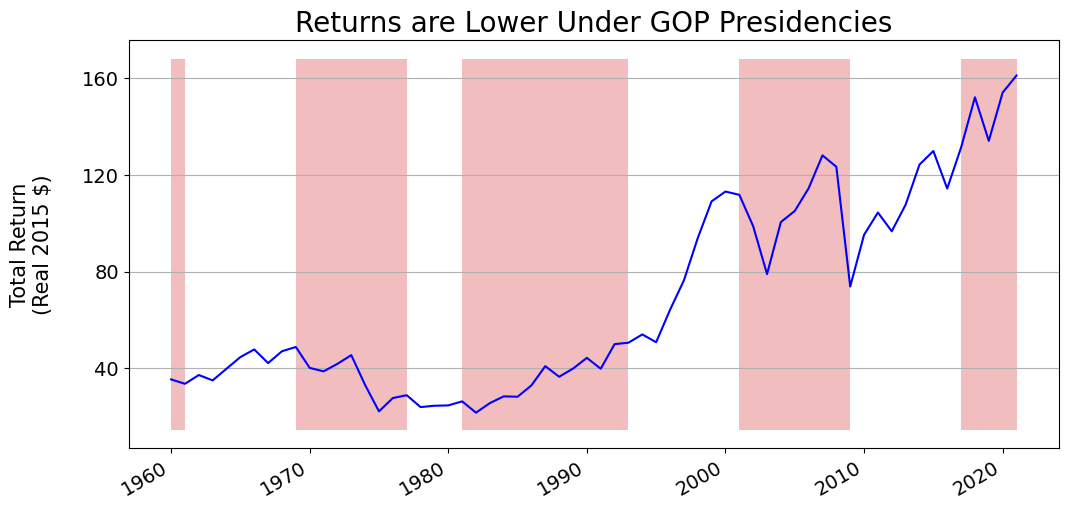

In [10]:
# Plot real total returns. Shade GOP presidential terms
# convenience function

def plot_series(ax, df, index='Date', cols=['Real_Total_Return'], area='GOP'):
    # convert area variable to boolean
    df[area] = df[area].astype(int).astype(bool)
    # set up an index based on date
    df = df.set_index(keys=index, drop=False)
    # line plot
    df.plot(ax=ax, x=index, y=cols, color='blue', legend=False)
    # extract limits
    y1, y2 = ax.get_ylim()
    ax.fill_between(
        df[index].index, y1=y1, y2=y2, where=df[area], facecolor='tab:red', alpha=0.3
    )
    return ax

# set up figure, axis
f, ax = plt.subplots(figsize=(12, 6))
plot_series(ax, df)
ax.set_title('Returns are Lower Under GOP Presidencies', fontsize = 20)

# ax.grid(visible=False)
ax.grid(axis='y')
ax.set_xlabel('')
ax.set_ylabel('Total Return\n(Real 2015 $)\n ', fontsize = 15)

ax.set_yticks([40, 80, 120, 160])
for text in ax.get_yticklabels():
    text.set_fontsize(14)

for text in ax.get_xticklabels():
    text.set_fontsize(14)


# plt.show()
# f.savefig('matts_plot.png')

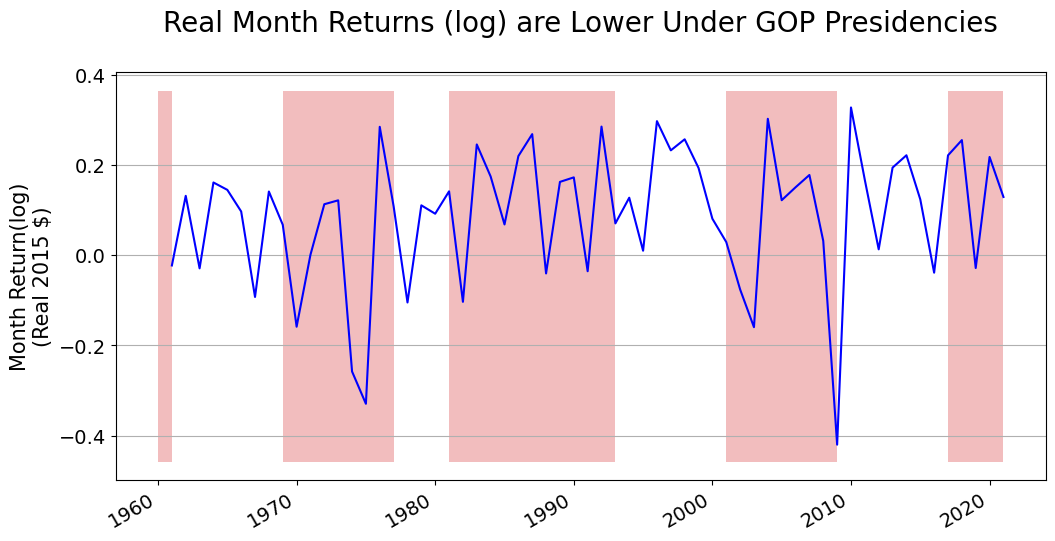

In [9]:
# Plot log total returns over time. Shade GOP presidential terms
# convenience function
def plot_series(ax, df, index='Date', cols=['log_Real_Month_Return'], area='GOP'):
    # convert area variable to boolean
    df[area] = df[area].astype(int).astype(bool)
    # set up an index based on date
    df = df.set_index(keys=index, drop=False)
    # line plot
    df.plot(ax=ax, x=index, y=cols, color='blue', legend=False)
    # extract limits
    y1, y2 = ax.get_ylim()
    ax.fill_between(df[index].index, y1=y1, y2=y2, where=df[area], facecolor='tab:red', alpha=0.3)
    return ax

# set up figure, axis
f, ax = plt.subplots(figsize=(12, 6))
plot_series(ax, df)

# Set title and labels
ax.set_title('Real Month Returns (log) are Lower Under GOP Presidencies\n ', fontsize=20)
ax.set_xlabel('')
ax.set_ylabel('Month Return(log)\n(Real 2015 $)', fontsize=15)

# Set tick label size to 14 for both x and y axes
ax.tick_params(axis='both', which='major', labelsize=14)

# Add gridlines and show plot
ax.grid(axis='y')
plt.show()

In [77]:
# Run OLS regression of Monthly earnings onto GOP president flag
# Outcome real earnings next period. GOP president is pre-determined. 
df['GOPlag'] = df['GOP'].shift()

results = sm.formula.ols(formula = 'log_Real_Month_Return ~ GOPlag', data=df).fit(cov_type='HC3')
print(results.summary())

                              OLS Regression Results                             
Dep. Variable:     log_Real_Month_Return   R-squared:                       0.033
Model:                               OLS   Adj. R-squared:                  0.025
Method:                    Least Squares   F-statistic:                     4.424
Date:                   Mon, 07 Oct 2024   Prob (F-statistic):             0.0375
Time:                           13:59:37   Log-Likelihood:                 57.587
No. Observations:                    122   AIC:                            -111.2
Df Residuals:                        120   BIC:                            -105.6
Df Model:                              1                                         
Covariance Type:                     HC3                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept     